In [1]:
import netgen.gui
from ngsolve import *
from netgen.geom2d import SplineGeometry
from math import pi
import matplotlib.pyplot as plt
import numpy as np

In [55]:
geo = SplineGeometry()
geo.AddRectangle((-1,-1),(1,1),bc=1)
mesh = Mesh( geo.GenerateMesh(maxh=0.5))

V = H1(mesh, order=3, dirichlet=[1])
# finite element space and gridfunction to represent the heatflux:
space_flux = HDiv(mesh, order=2)
gf_flux = GridFunction(space_flux, "flux")

u = V.TrialFunction()
v = V.TestFunction()

r = sqrt(x*x+y*y)
r2 = x*x+y*y
R = 1/2

alpha = IfPos(r-R,2*log(1/R),1)

solution = IfPos(r-R,1.0/16.0*log(r2)/log(R*R),1.0/8.0-r2/4.0)
sol_flux = alpha * IfPos(r-R,1.0/16.0/log(R*R)*
                     CoefficientFunction((2*x/r2,2*y/r2)),
                     CoefficientFunction((-x/2.0,-y/2.0)))
rhs = IfPos(r-R,0,1)

In [56]:
a = BilinearForm(V, symmetric=False)
a += SymbolicBFI(alpha*grad(u)*grad(v))

f = LinearForm(V)
f += SymbolicLFI(rhs*v)

gfu = GridFunction(V)
flux = alpha * grad(gfu)
#gf_flux.Set(flux)
Draw (gfu,mesh,"u")
Draw (grad(gfu),mesh,"grad_u")

In [57]:
def SolveBVP():
    V.Update()
    gfu.Update()
    
    #space_flux.Update()
    #gf_flux.Update()
    
    a.Assemble()
    f.Assemble()
    gfu.Set(solution)
    f.vec.data -= a.mat * gfu.vec
    gfu.vec.data += a.mat.Inverse(V.FreeDofs(),"umfpack") * f.vec
    Redraw (blocking=True)

In [58]:
def CalcError():
    space_flux.Update()
    gf_flux.Update()
    # interpolate finite element flux into H(div) space:
    gf_flux.Set (flux)
    # compute error on every element:
    
    # for 6.4.1 remove that: 
    err = 1/alpha*(flux-gf_flux)*(flux-gf_flux)
    
    # for 6.4.2 remove that: 
    err = 1/alpha*(flux-sol_flux)*(flux-sol_flux)
    
    
    elerr = Integrate (err, mesh, VOL, element_wise=True)
    
    # sort elements (corresponding to error contribution)
    err_and_el_sorted = sorted([(entry,i) for i, entry in enumerate(elerr)], key= lambda x:-x[0])
    # reset marks
    marks = [False for el in mesh.Elements()]

    # mark element with largest error until 10% of the error is on marked elements:
    sumerr = sum(elerr)    
    accsum = 0
    for err,el in err_and_el_sorted:
        if accsum < 0.1 * sumerr:
            marks[el] = True
            accsum += err
        else:
            break
    
    print ("V.ndof = ", V.ndof)
    H1error = sqrt(Integrate (1/alpha*(flux - sol_flux)*(flux - sol_flux), mesh, VOL))
    print ("weighted H1 (semi norm) error = ", H1error)
    L2error = sqrt(Integrate ((gfu - solution)*(gfu - solution), mesh, VOL))
    print ("hier L2 error = ", L2error)
    
        # call the refinement according to the marks:
    for el in mesh.Elements():
        mesh.SetRefinementFlag(el, marks[el.nr])
    return  V.ndof,sqrt(sumerr)

In [59]:
with TaskManager():
    #L2error_2 = []
    H1error_2 = []
    d_2 = []
    #L2error_2 = []
    #d_2 = []
    while V.ndof < 10000:  
        SolveBVP()
        d,H1flux = CalcError()
        #L2error_2.append(temp)
        H1error_2.append(H1flux)
        d_2.append(d)
        mesh.Refine()
    SolveBVP()

V.ndof =  187
weighted H1 (semi norm) error =  0.02495905425934296
hier L2 error =  0.002462722808148026
V.ndof =  223
weighted H1 (semi norm) error =  0.02288847144979913
hier L2 error =  0.002679415229679176
V.ndof =  268
weighted H1 (semi norm) error =  0.019708717579419388
hier L2 error =  0.0012312095321791517
V.ndof =  340
weighted H1 (semi norm) error =  0.01846489739797801
hier L2 error =  0.0011298771332237318
V.ndof =  430
weighted H1 (semi norm) error =  0.01700835274874273
hier L2 error =  0.0010442249707573851
V.ndof =  493
weighted H1 (semi norm) error =  0.015420080776671492
hier L2 error =  0.001347032138694285
V.ndof =  538
weighted H1 (semi norm) error =  0.014861295118549181
hier L2 error =  0.0004924759022128968
V.ndof =  673
weighted H1 (semi norm) error =  0.014902251195835391
hier L2 error =  0.0008763855560347143
V.ndof =  754
weighted H1 (semi norm) error =  0.014146959621662951
hier L2 error =  0.0008967377723067135
V.ndof =  868
weighted H1 (semi norm) error 

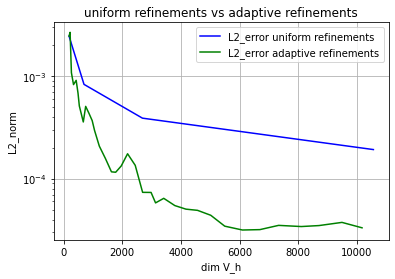

In [66]:
plt.figure()
plt.title("uniform refinements vs adaptive refinements")
plt.grid()
plt.semilogy(d_1,L2error_1,'b',label='L2_error uniform refinements')
plt.semilogy(d_2,L2error_2[0:35],'g',label='L2_error adaptive refinements')
plt.xlabel("dim V_h")
plt.ylabel("L2_norm")
plt.legend()
plt.savefig('uniform refinements vs adaptive refinements')

### explenation
The blue line represents the error with the uniform refinments. That means the mesh is uniformt over the hole domain. The other line th error from the adaptive one. The algorytmus measures the error and define the new grid in the "critical area". It lies on the boundary on the circuit with an radius of $R$.

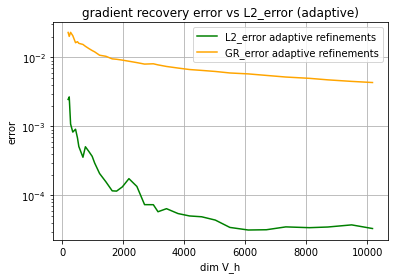

In [67]:
plt.figure()
plt.title("gradient recovery error vs L2_error (adaptive)")
plt.grid()
#plt.semilogy(d_1,L2error_1)
plt.semilogy(d_2,L2error_2[0:35],'g',label='L2_error adaptive refinements')
plt.semilogy(d_2,H1error_2[0:35],color='orange',label='GR_error adaptive refinements')
plt.xlabel("dim V_h")
plt.ylabel("error")
plt.legend()
plt.savefig('gradient recovery error vs L2_error (adaptive)')